# 4.5. 权重衰减

# 4.5.1. 高维线性回归

In [3]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [4]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
# 生成训练数据：y = Wx + b + noise
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

# 4.5.2. 从零开始实现

4.5.2.1. 初始化模型参数

In [5]:
def init_params():
    """初始化参数, w为正态分布, b为0"""
    W = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [W, b]

4.5.2.2. 定义L2范数惩罚

In [6]:
def l2_penalty(w):
    """L2罚函数:0.5*平方和"""
    return torch.sum(w.pow(2)) / 2

4.5.2.3. 定义训练代码实现

In [7]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    # 前面画图监测效果的类：Animator
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log', 
                            xlim=[5, num_epochs], legend=['train', 'test'])
    
    # training
    for epoch in range(num_epochs):
        for X,y in train_iter:
            # loss add l2 penalty
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr=lr, batch_size=batch_size)
        if (epoch + 1) % 5 == 0:
            # 5epoch绘图一次
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    
    # item()将单元素张量转化为标量
    print('w的L2范数是：', torch.norm(w).item())

4.5.2.4. 忽略正则化直接训练

w的L2范数是： 12.852785110473633


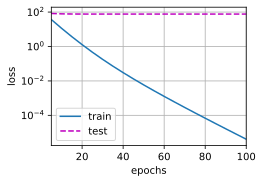

In [8]:
train(lambd=0)

4.5.2.5. 使用权重衰减

w的L2范数是： 0.3395081162452698


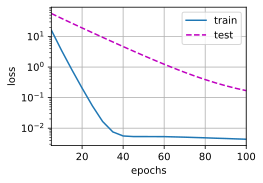

In [9]:
train(lambd=3)

# 4.5.3. 简洁实现

In [11]:
def train_concise(wd):
    """直接用torch搭建网络及初始化"""
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    # init parameter
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr
    )
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[2, num_epochs], legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
            
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))

    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 13.298201560974121


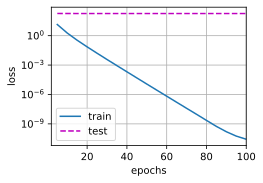

In [12]:
train_concise(0)

w的L2范数： 0.3777494430541992


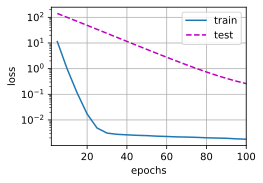

In [13]:
train_concise(3)

# 4.5.4. 小结

正则化是处理过拟合的常用方法：在训练集的损失函数中加入惩罚项，以降低学习到的模型的复杂度。

保持模型简单的一个特别的选择是使用L2惩罚的权重衰减。这会导致学习算法更新步骤中的权重衰减。

权重衰减功能在深度学习框架的优化器中提供。

在同一训练代码实现中，不同的参数集可以有不同的更新行为。

# 4.5.5. 练习

In [14]:
def train_concise_1ambd(wd):
    """直接用torch搭建网络及初始化"""
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    # init parameter
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr
    )
    # animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
    #                         xlim=[2, num_epochs], legend=['train', 'test'])
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
            
        # if (epoch + 1) % 5 == 0:
        #     animator.add(epoch + 1,
        #                  (d2l.evaluate_loss(net, train_iter, loss),
        #                   d2l.evaluate_loss(net, test_iter, loss)))

    return d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net, test_iter, loss)

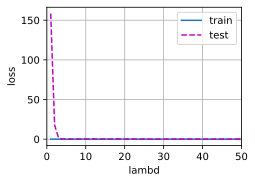

In [21]:
animator = d2l.Animator(xlabel='lambd', ylabel='loss',
                        xlim=[0, 50], legend=['train', 'test'])
for lambd in range(50):
    l_train, l_test = train_concise_1ambd(lambd)
    animator.add(lambd + 1, (l_train, l_test))